# Import

In [24]:
import pandas
import sklearn
import evaluation
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [12]:
GPU_fix = "MemoryFix" # Choose "Disable", "MemoryFix" or "None"

if GPU_fix == "Disable":
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
elif GPU_fix == "MemoryFix":
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


In [25]:
def preprocess_data(X, scaler=None):
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

# Read training data

In [13]:
# https://www.kaggle.com/sionek/ugbc-gs
folder = 'tau_data/'
data = pandas.read_csv(folder + 'training.csv', index_col='id')
#--------------- feature engineering -------------- #
def add_features(df):
    # features used by the others on Kaggle
    df['NEW_FD_SUMP']=df['FlightDistance']/(df['p0_p']+df['p1_p']+df['p2_p'])
    df['NEW5_lt']=df['LifeTime']*(df['p0_IP']+df['p1_IP']+df['p2_IP'])/3
    df['p_track_Chi2Dof_MAX'] = df.loc[:, ['p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof']].max(axis=1)
    #df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError'] # modified to:
    df['flight_dist_sig2'] = (df['FlightDistance']/df['FlightDistanceError'])**2
    # features from phunter
    df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError']
    df['NEW_IP_dira'] = df['IP']*df['dira']
    df['p0p2_ip_ratio']=df['IP']/df['IP_p0p2']
    df['p1p2_ip_ratio']=df['IP']/df['IP_p1p2']
    df['DCA_MAX'] = df.loc[:, ['DOCAone', 'DOCAtwo', 'DOCAthree']].max(axis=1)
    df['iso_bdt_min'] = df.loc[:, ['p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT']].min(axis=1)
    df['iso_min'] = df.loc[:, ['isolationa', 'isolationb', 'isolationc','isolationd', 'isolatione', 'isolationf']].min(axis=1)
    # My:
    # new combined features just to minimize their number;
    # their physical sense doesn't matter
    df['NEW_iso_abc'] = df['isolationa']*df['isolationb']*df['isolationc']
    df['NEW_iso_def'] = df['isolationd']*df['isolatione']*df['isolationf']
    df['NEW_pN_IP'] = df['p0_IP']+df['p1_IP']+df['p2_IP']
    df['NEW_pN_p']  = df['p0_p']+df['p1_p']+df['p2_p']
    df['NEW_IP_pNpN'] = df['IP_p0p2']*df['IP_p1p2']
    df['NEW_pN_IPSig'] = df['p0_IPSig']+df['p1_IPSig']+df['p2_IPSig']
    #My:
    # "super" feature changing the result from 0.988641 to 0.991099
    df['NEW_FD_LT']=df['FlightDistance']/df['LifeTime']
    return df

print("Add features")
train_df = add_features(data)

print("Eliminate features")
filter_out = ['id', 'min_ANNmuon', 'production', 'mass', 'signal','p0_IP', 'p1_IP', 'p2_IP',
              'IP_p0p2', 'IP_p1p2',
              'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig',
              'DOCAone', 'DOCAtwo', 'DOCAthree','p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT','isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf',
              'p0_eta', 'p1_eta', 'p2_eta','p0_p', 'p1_p', 'p2_p','p0_pt', 'p1_pt', 'p2_pt']
filter_out1 = ['id', 'min_ANNmuon', 'production', 'mass', 'signal',
              'SPDhits','CDF1', 'CDF2', 'CDF3',
              'p0_pt', 'p1_pt', 'p2_pt',
              'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta',
              'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf',
              'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT',
              'p0_IP', 'p1_IP', 'p2_IP',
              'IP_p0p2', 'IP_p1p2',
              'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig',
              'DOCAone', 'DOCAtwo', 'DOCAthree']

Add features
Eliminate features


In [14]:
#modified
variables_mod = list(f for f in data.columns if f not in filter_out)
print(len(variables_mod))

32


In [27]:
train_df = data[variables_mod]
train_df, scaler = preprocess_data(train_df)

In [28]:
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
val = train_df[~msk]

In [29]:
print('validation samples:',len(val))
print('train samples:',len(train))

validation samples: 13555
train samples: 53997


# Baseline training

In [31]:
#Create training arrays
x_train = train
y_train = data['signal'][msk].to_numpy()
y_train = np.expand_dims(y_train,1)
x_val = val
y_val = data['signal'][~msk].to_numpy()
y_val = np.expand_dims(y_val,1)

In [74]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(len(variables_mod)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.05)), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.05)), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.05)),  
  tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.layers import PReLU
model = Sequential()
model.add(Input(shape=len(variables_mod)))
model.add(Dropout(0.15))
model.add(Dense(75))
model.add(PReLU())

model.add(Dropout(0.13))
model.add(Dense(60))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(45))
model.add(PReLU())

model.add(Dropout(0.09))
model.add(Dense(30))
model.add(PReLU())

model.add(Dropout(0.07))
model.add(Dense(15))
model.add(PReLU())

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_59 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 75)                2475      
_________________________________________________________________
p_re_lu_46 (PReLU)           (None, 75)                75        
_________________________________________________________________
dropout_60 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 60)                4560      
_________________________________________________________________
p_re_lu_47 (PReLU)           (None, 60)                60        
_________________________________________________________________
dropout_61 (Dropout)         (None, 60)              

In [77]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [78]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data = (x_val,y_val))
history_1 = model1.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data = (x_val,y_val))

Epoch 1/100
422/422 [==============================] - 5s 10ms/step - loss: 0.4228 - accuracy: 0.8162 - val_loss: 0.3099 - val_accuracy: 0.8713
Epoch 2/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3466 - accuracy: 0.8515 - val_loss: 0.3035 - val_accuracy: 0.8716
Epoch 3/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3403 - accuracy: 0.8560 - val_loss: 0.3013 - val_accuracy: 0.8738
Epoch 4/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3356 - accuracy: 0.8593 - val_loss: 0.3008 - val_accuracy: 0.8750
Epoch 5/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3304 - accuracy: 0.8603 - val_loss: 0.3067 - val_accuracy: 0.8736
Epoch 6/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3289 - accuracy: 0.8634 - val_loss: 0.2960 - val_accuracy: 0.8744
Epoch 7/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3248 - accuracy: 0.8642 - val_loss: 0.3006 - val_accuracy: 0.874

Epoch 58/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3116 - accuracy: 0.8704 - val_loss: 0.2873 - val_accuracy: 0.8812
Epoch 59/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3152 - accuracy: 0.8668 - val_loss: 0.2854 - val_accuracy: 0.8812
Epoch 60/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3196 - accuracy: 0.8671 - val_loss: 0.2857 - val_accuracy: 0.8805
Epoch 61/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3130 - accuracy: 0.8678 - val_loss: 0.2899 - val_accuracy: 0.8822
Epoch 62/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3141 - accuracy: 0.8679 - val_loss: 0.2897 - val_accuracy: 0.8802
Epoch 63/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3125 - accuracy: 0.8677 - val_loss: 0.2909 - val_accuracy: 0.8805
Epoch 64/100
422/422 [==============================] - 4s 9ms/step - loss: 0.3146 - accuracy: 0.8695 - val_loss: 0.2905 - val_accuracy:

Epoch 15/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3292 - accuracy: 0.8582 - val_loss: 0.2942 - val_accuracy: 0.8767
Epoch 16/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3316 - accuracy: 0.8584 - val_loss: 0.2961 - val_accuracy: 0.8778
Epoch 17/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3294 - accuracy: 0.8605 - val_loss: 0.2890 - val_accuracy: 0.8783
Epoch 18/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3211 - accuracy: 0.8626 - val_loss: 0.2898 - val_accuracy: 0.8773
Epoch 19/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3224 - accuracy: 0.8617 - val_loss: 0.2915 - val_accuracy: 0.8774
Epoch 20/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3270 - accuracy: 0.8617 - val_loss: 0.2899 - val_accuracy: 0.8779
Epoch 21/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3200 - accuracy: 0.8659 - val_loss: 0.2948 - val_accuracy:

Epoch 72/100
422/422 [==============================] - 4s 8ms/step - loss: 0.3127 - accuracy: 0.8655 - val_loss: 0.2952 - val_accuracy: 0.8811
Epoch 73/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3161 - accuracy: 0.8665 - val_loss: 0.2872 - val_accuracy: 0.8802
Epoch 74/100
422/422 [==============================] - 4s 8ms/step - loss: 0.3169 - accuracy: 0.8673 - val_loss: 0.2956 - val_accuracy: 0.8743
Epoch 75/100
422/422 [==============================] - 4s 8ms/step - loss: 0.3171 - accuracy: 0.8640 - val_loss: 0.2916 - val_accuracy: 0.8778
Epoch 76/100
422/422 [==============================] - 4s 8ms/step - loss: 0.3167 - accuracy: 0.8645 - val_loss: 0.2868 - val_accuracy: 0.8818
Epoch 77/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3193 - accuracy: 0.8642 - val_loss: 0.2906 - val_accuracy: 0.8753
Epoch 78/100
422/422 [==============================] - 3s 8ms/step - loss: 0.3149 - accuracy: 0.8637 - val_loss: 0.2857 - val_accuracy:

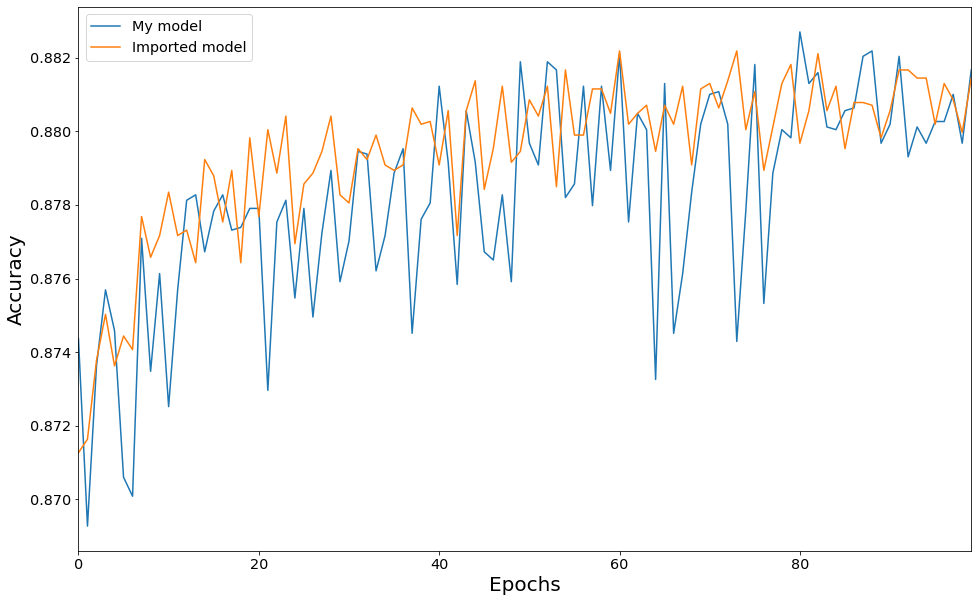

In [81]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure(figsize=(16,10))
plt.xlabel('Epochs',fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
val = plt.plot(history_1.epoch, history_1.history['val_'+'accuracy'],
             label='My model')
plt.plot(history.epoch, history.history['val_'+'accuracy'],
             label='Imported model')
plt.legend()
plt.xlim([0,max(history_1.epoch)])
plt.show()

# Check agreement test

In [123]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv', index_col='id')
check_agreement = add_features(check_agreement)
agreement_probs = model.predict(check_agreement[variables_mod].to_numpy()).squeeze()
print(agreement_probs)
ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric', ks, ks < 0.09)

[0.1335563  0.00778783 0.30263552 ... 0.79727703 0.9761328  0.9687413 ]
KS metric 0.1900190813022734 False


# Check correlation test

In [134]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv', index_col='id')
check_correlation = add_features(check_correlation)
correlation_probs = model.predict(check_correlation[variables_mod].to_numpy()).squeeze()
#pd.DataFrame(correlation_probs,
  #                 columns=[variables])
print(correlation_probs)
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric', cvm, cvm < 0.002)

[0.01931227 0.10880692 0.22141731 ... 0.6481841  0.34362435 0.0247995 ]
CvM metric 0.0010665308092605871 True


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [ ]:
train_eval = data[data['min_ANNmuon'] > 0.4]
train_probs = model.predict(train_eval[variables_mod].to_numpy()).squeeze()
AUC = sklearn.metrics.roc_auc_score(train_eval['signal'], train_probs)
print('AUC', AUC)

# Predict test, create file for kaggle

In [42]:
result = pandas.DataFrame({'id': test.index})
result['prediction'] = model.predict(test[variables].to_numpy()).squeeze()

In [43]:
result.to_csv('submission.csv', index=False, sep=',')

In [ ]:
!ls -l submission.csv

In [ ]:
result.to_csv?